# Module 11 -- Transfer Entropy in Cellular Automata

In this activity we will examine Transfer Entropy (TE) in Elementary Cellular Automata rule 54 in a similar fashion to what we did for AIS in the previous module. We will compute the local TE values and how they relate to emergent structure.

1. Make sure that you had *downloaded* the sample time-series as directed in the AIS activity on Cellular Automata, else go back and do that now.
2. Now open the AutoAnalyser and select Transfer Entropy. Select a Discrete estimator, select your CA data file, tick the checkbox for `All pairs?`, enter the `k` history value that you determined for AIS in the Information Storage module (my analysis suggested `k=15`), and -- most importantly -- untick the checkbox for `Compute result?` (we don't want to run this computation, it will take a lot of time!), and click `Generate Code`.
3. Copy and paste the generated code into the code cells below.

In [1]:
# Paste the import and JVM startup lines here:

from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/home/joseph/JIDT/infodynamics-dist-1.6.1/demos/python")
import readIntsFile

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "/home/joseph/JIDT/infodynamics-dist-1.6.1/infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)


In [2]:
# Paste the code loading and analysing the data here:

# 0. Load/prepare the data:
dataRaw = readIntsFile.readIntsFile("/home/joseph/TeachingPlayground/CSYS5030/Week10/ca54.txt")
# As numpy array:
data = numpy.array(dataRaw)
# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.discrete").TransferEntropyCalculatorDiscrete
calc = calcClass(2, 15, 1, 1, 1, 1)
# 2. No other properties to set for discrete calculators.

# 3. Initialise the calculator for (re-)use:
calc.initialise()

# Compute for all targets:
for d in range(10000):
    # For each target:
    s = (d - 1) % 10000; # Take the source to the left
    source = JArray(JInt, 1)(data[:, s].tolist())
    destination = JArray(JInt, 1)(data[:, d].tolist())

    # 4. Supply the sample data:
    calc.addObservations(source, destination)

# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()

print("TE_Discrete(1 cell to left) = %.4f bits, using %d samples" %\
    (result, calc.getNumObservations()))

TE_Discrete(1 cell to left) = 0.0818 bits, using 5850000 samples


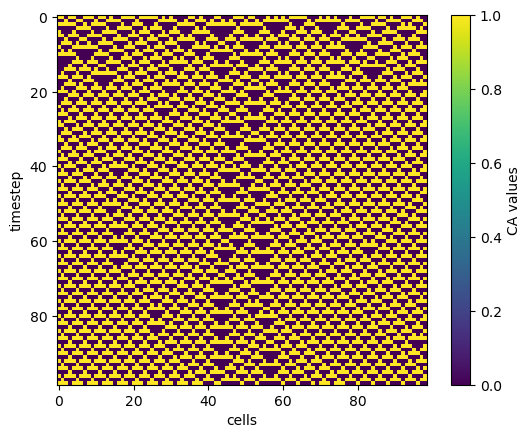

In [3]:
# This code block plots a sample of 100 time steps for 100 cells of the CA:
import matplotlib.pyplot as plt
plt.imshow(data[:99,:99]) # Plotting the first 100 time steps for first 100 cells
plt.xlabel('cells');
plt.ylabel('timestep');
cbar = plt.colorbar()
cbar.set_label('CA values');

4. Now, examine how the generated code is computing the TE for each cell pair. We want to change a few things here:
    * We don't want to compute TE for all pairs, only for sources in the neighbourhood of the target since we know those are directly contributing information to the state update of the target (see comparison of TE to causality in the lecture). We'll focus on sources one cell to the left of the target (i.e. with cell index being one less).
    * As we did for AIS in the previous session, we would get a much more accurate result if we could make a TE estimation by pooling all of the samples for the pairs (with source one cell to left of target) together. Reflect on why pooling the samples for technically different paired processes is valid here too, and think of a data set where it would not be a valid approach.

    As such, change the code so that, instead of making a separate calculation for each source-target pair, we make one calculation where the samples from all pairs (with source cell one to left of the target) are used together:
    * First remove the for-loop over sources (but leave all of the code inside that loop).
    * Then assign the value for `s` inside the loop over destination cells to be one less than `d`. You can't just use `s = d-1;` though, because we use periodic boundary conditions so that `d==0` has `s==9999` as its neighbour. Instead, use: `s = (d - 1) % 10000;`
    * Next, move step 3 (calculator initialisation) before the loop, and step 5 (the calculation of the final value, and the `print` statement) after the loop.
    * You'll also need to rewrite the `print` statement without `s` and `d`, since they're not used outside the loop (make sure you rewrite the part of the print statement that references them with `%d` symbols as well!). Also, when you print the result, check the number of samples that were used via `calc.getNumObservations()`, which should report a number of observations consistent with having used all of the samples from all relevant pairs. If it still reports 599, obviously you've only used samples from one pair.
5. Run your code and check the TE value computed is arouns 0.08 bits.
6. Now we move on to compute the **local** TE values.
    * We'll insert new code in the cell below to compute the local values. Add another loop over all cells (copying the whole for loop that is already earlier in the code, but don't copy anything from outside the for loop). Delete the copied step 4 line where the sample data are supplied, replacing it with a calculation of local values of TE into this destination cell using: `localTEForThisCell = calc.computeLocalFromPreviousObservations(source, destination);`. Note that this call evaluates the local TE values for the given samples, based on the PDFs computed from across the whole of the CA in the previous for loop.
    * Create an empty matrix `locals = numpy.zeros(data.shape);` before this new for loop. Store all of the columns of local TE values together in this one 2D matrix for all of the cells; e.g. after computing `localTEForThisCell` for column `d` store it as `locals[:,d] = localTEForThisCell;`
    * After the loop, let's plot a small segment of these local values. A simple way to do this would be:
      ```python
      plt.imshow(locals[:99,:99]) # Plotting the first 100 time steps for first 100 cells
      plt.xlabel('cells');
      plt.ylabel('timestep');
      cbar = plt.colorbar()
      cbar.set_label('TE (bits)');
      ```
      However the colours could be arranged a little better (so that we use blue for positive AIS and red for negative). So instead first import some extra libraries from matplotlib: `import matplotlib.cm as cm; import matplotlib.colors as mplcolors` and then add the following argument to the `plt.imshow()` call: `cmap=cm.coolwarm_r, norm=mplcolors.CenteredNorm()`
    * Run the code!
    * (You can ignore the first `k` time steps here being 0 -- it's simply not possible to compute a local value until we've accumulated `k` time steps).
    * Observe which emergent structures execute the strongest information transfer to the right (i.e. from a source one cell to the left). You may find it useful to replot the raw values here again for comparison, copying step 1 from above. Does this align with our intuition from the lecture? What do the areas with negative local TE values mean? (Recall the meaning of negative values of local conditional mutual information, and think about what the source at the left is telling us, in the context of the target past, when the local TE goes negative).
    * For further details, you can compare to Fig. 4b and section IV.E (and references therein) of the JIDT paper.

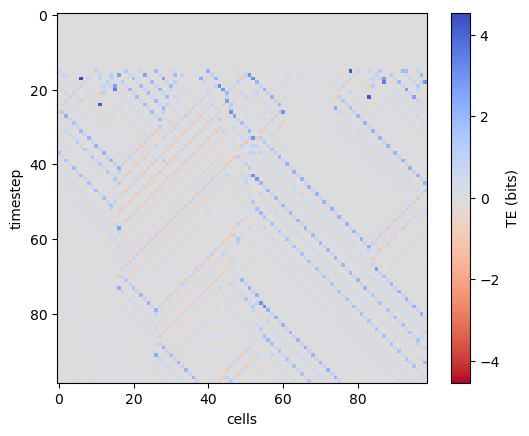

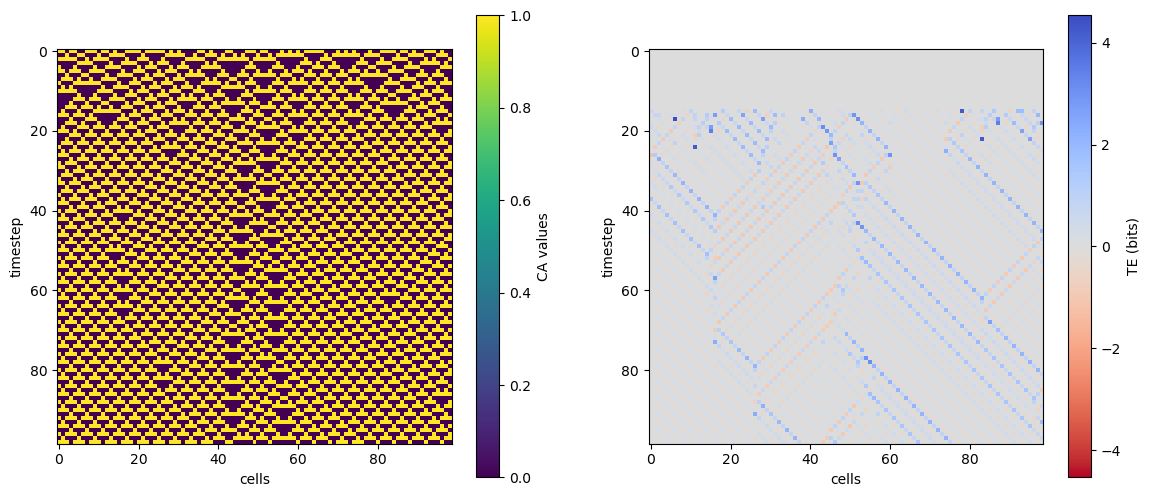

In [4]:
# Insert the code to compute the local TE values here:

locals = numpy.zeros(data.shape);
# Compute for all targets:
for d in range(10000):
    # For each target:
    s = (d - 1) % 10000; # Take the source to the left
    source = JArray(JInt, 1)(data[:, s].tolist())
    destination = JArray(JInt, 1)(data[:, d].tolist())

    # 4. Compute the local TE values:
    localTEForThisCell = calc.computeLocalFromPreviousObservations(source, destination);
    locals[:,d] = localTEForThisCell;

import matplotlib.cm as cm
import matplotlib.colors as mplcolors
plt.imshow(locals[:99,:99], cmap=cm.coolwarm_r, norm=mplcolors.CenteredNorm()) # Plotting the first 100 time steps for first 100 cells
plt.xlabel('cells');
plt.ylabel('timestep');
cbar = plt.colorbar()
cbar.set_label('TE (bits)');

# Finally plotting the raw values together with the information values for comparison:
plt.figure(figsize=(14,6))
# First plot the raw CA values
plt.subplot(1,2,1) # left subplot
plt.imshow(data[:99,:99]) # Plotting the first 100 time steps for first 100 cells
plt.xlabel('cells');
plt.ylabel('timestep');
cbar = plt.colorbar()
cbar.set_label('CA values');
# Next plot the TE values
plt.subplot(1, 2, 2); # right subplot
plt.imshow(locals[:99,:99], cmap=cm.coolwarm_r, norm=mplcolors.CenteredNorm()) # Plotting the first 100 time steps for first 100 cells
plt.xlabel('cells');
plt.ylabel('timestep');
cbar = plt.colorbar()
cbar.set_label('TE (bits)');

7. _Optional extensions_:
    * Was the calculated TE statistically significant?
    * Try examining information flow one step to the left at each point in space and time instead (think about what you would need to change in the code). What do you expect from the results?
    * Try running your code on other CA rules, with and without emergent structures.
    * Try examining conditional transfer entropies, as per item 10 in the tutorial.